# 第4章: 言語解析

問題30から問題35までは、以下の文章`text`（太宰治の『走れメロス』の冒頭部分）に対して、言語解析を実施せよ。問題36から問題39までは、国家を説明した文書群（日本語版ウィキペディア記事から抽出したテキスト群）をコーパスとして、言語解析を実施せよ。

In [29]:
text = "メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。"

## 30. 動詞
文章`text`に含まれる動詞をすべて表示せよ。

In [8]:
%%capture cap
import MeCab
import ipadic

mecab = MeCab.Tagger(ipadic.MECAB_ARGS)
nodes = mecab.parseToNode(text)
while nodes:
  if nodes.feature.split(",")[0] == "動詞":
    print(nodes.surface)
  nodes = nodes.next


In [9]:
with open('../outputs/ch04/result30.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

し
除か
なら
し
わから
吹き
遊ん
暮し
来



## 31. 動詞の原型
文章`text`に含まれる動詞と、その原型をすべて表示せよ。

In [27]:
%%capture cap
import sudachipy
dict = sudachipy.Dictionary()
tokenizer = dict.create()
text = "メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。"
for token in tokenizer.tokenize(text):
    if token.part_of_speech()[0] == "動詞":
        text = token.surface()
        base = token.normalized_form()
        print(f"{text}\t{base}")

In [28]:
with open('../outputs/ch04/result31.txt', 'w') as f:
    f.write(cap.stdout)

## 32. 「AのB」
文章`text`において、2つの名詞が「の」で連結されている名詞句をすべて抽出せよ。

In [16]:
%%capture cap
tokens_list = []
tokens = tokenizer.tokenize(text)
for token in tokens:
  tokens_list.append((token.surface, token.part_of_speech.split(",")[0]))

for i in range(1, len(tokens_list)-1):
  if tokens_list[i-1][1] == "名詞" and tokens_list[i+1][1] == "名詞" and tokens_list[i][0] == "の":
    print(tokens_list[i-1][0], tokens_list[i][0], tokens_list[i+1][0])

In [17]:
with open('../outputs/ch04/result32.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

暴虐 の 王
村 の 牧人



## 33. 係り受け解析

文章`text`に係り受け解析を適用し、係り元と係り先のトークン（形態素や文節などの単位）をタブ区切り形式ですべて抽出せよ。

In [ ]:
%%capture cap
import spacy
import ginza

nlp = spacy.load("ja_ginza")
text = "メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。"
doc = nlp(text)
for token in doc:
  if token.dep_ != "ROOT":
    print(token.text+"\t"+token.head.text)

In [13]:
with open('../outputs/ch04/result33.txt', 'w') as f:
    f.write(cap.stdout)

## 34. 主述の関係
文章`text`において、「メロス」が主語であるときの述語を抽出せよ。

In [43]:
%%capture cap
import spacy
import ginza

nlp = spacy.load("ja_ginza")
text = "メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。"
doc = nlp(text)
for token in doc:
    if token.text == "メロス" and token.dep_ == "nsubj":
        print(token.head)

In [44]:
with open('../outputs/ch04/result34.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

激怒
牧人



## 35. 係り受け木
「メロスは激怒した。」の係り受け木を可視化せよ。

In [19]:
doc_short = nlp("メロスは激怒した。")
spacy.displacy.serve(doc_short, style="dep", port=9199)


Using the 'dep' visualizer
Serving on http://0.0.0.0:9199 ...

Shutting down server on port 9199.


## 36. 単語の出現頻度

問題36から39までは、Wikipediaの記事を以下のフォーマットで書き出したファイル[jawiki-country.json.gz](/data/jawiki-country.json.gz)をコーパスと見なし、統計的な分析を行う。

* 1行に1記事の情報がJSON形式で格納される
* 各行には記事名が"title"キーに、記事本文が"text"キーの辞書オブジェクトに格納され、そのオブジェクトがJSON形式で書き出される
* ファイル全体はgzipで圧縮される

まず、第3章の処理内容を参考に、Wikipedia記事からマークアップを除去し、各記事のテキストを抽出せよ。そして、コーパスにおける単語（形態素）の出現頻度を求め、出現頻度の高い20語とその出現頻度を表示せよ。

In [2]:
import sudachipy
dict = sudachipy.Dictionary()
tokenizer = dict.create()

In [23]:
%%capture cap
import pandas as pd
import re
from collections import defaultdict
doc = pd.read_json("../data/ch04/jawiki-country.json.gz", lines=True)

def remove_markup(text):
    r1 = re.compile(r"'+")
    r2 = re.compile(r'\[\[[^\]|]*\|([^\]]*?)\]\]')
    r3 = re.compile(r'\[\[([^\]]*?)\]\]')
    r4 = re.compile(r'\{\{lang\|[^|}]*\|([^}]+)\}\}')
    r5 = re.compile(r'<[^>]+>')
    r6 = re.compile(r'\[https?://[^ ]+\s([^\]]+)\]')
    r7 = re.compile(r'\[https?://[^\s]+\]')
    r8 = re.compile(r'\{\{(?:Cite|cite)[^}]*\|title\s*=\s*([^|}]+)[^}]*\}\}')
    r9 = re.compile(r'\{\{citypop\|(?:\{\{[^}]+\}\})?(.*?)\}\}')
    r10 = re.compile(r'\{\{flagu\|([^}]+)\}\}')
    r11 = re.compile(r'(={2,})\s*(.*?)\s*\1')
    r12 = re.compile(r'[\[\]\{\}\|\n]')

    text1 = r1.sub("", text)
    text2 = r2.sub(r'\1', text1)
    text3 = r3.sub(r'\1', text2)
    text4 = r4.sub(r'\1', text3)
    text5 = r5.sub('', text4)
    text6 = r6.sub(r'\1', text5)
    text7 = r7.sub('', text6)
    text8 = r8.sub(r'\1', text7)
    text9 = r9.sub(r'\1', text8)
    text10 = r10.sub(r'\1', text9)
    text11 = r11.sub(r'\2', text10)
    text12 = r12.sub('', text11)

    return text12

def chunk_text(text, size=10000):
    res = []
    for i in range(0, len(text), size):
        res.append(text[i:i + size])
    return res

d = defaultdict(int)
for text in doc["text"]:
    text = remove_markup(text)
    for chunk in chunk_text(text):
        for token in tokenizer.tokenize(chunk):
            d[token.surface()] += 1

d = [(v, k) for k, v in d.items()]
d = sorted(d, reverse = True)

for cnt, word in d[:20]:
    print(f"{repr(word)}\t{cnt}")

In [24]:
with open('../outputs/ch04/result36.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

' '	149262
'の'	95598
'、'	87426
'に'	63382
'。'	53199
'は'	51911
'が'	44184
'を'	39141
'て'	36054
'た'	35862
'と'	35054
'で'	34862
'し'	30034
'年'	29369
'='	24535
'・'	24394
'（'	19253
'）'	19205
'-'	16264
'れ'	13975



## 37. 名詞の出現頻度
コーパスにおける名詞の出現頻度を求め、出現頻度の高い20語とその出現頻度を表示せよ。

In [25]:
%%capture cap
from collections import defaultdict
d_noun = defaultdict(int)

def chunk_text(text, size=10000):
    res = []
    for i in range(0, len(text), size):
        res.append(text[i:i + size])
    return res

def remove_markup(text):
    r1 = re.compile(r"'+")
    r2 = re.compile(r'\[\[[^\]|]*\|([^\]]*?)\]\]')
    r3 = re.compile(r'\[\[([^\]]*?)\]\]')
    r4 = re.compile(r'\{\{lang\|[^|}]*\|([^}]+)\}\}')
    r5 = re.compile(r'<[^>]+>')
    r6 = re.compile(r'\[https?://[^ ]+\s([^\]]+)\]')
    r7 = re.compile(r'\[https?://[^\s]+\]')
    r8 = re.compile(r'\{\{(?:Cite|cite)[^}]*\|title\s*=\s*([^|}]+)[^}]*\}\}')
    r9 = re.compile(r'\{\{citypop\|(?:\{\{[^}]+\}\})?(.*?)\}\}')
    r10 = re.compile(r'\{\{flagu\|([^}]+)\}\}')
    r11 = re.compile(r'(={2,})\s*(.*?)\s*\1')
    r12 = re.compile(r'[\[\]\{\}\|\n]')

    text1 = r1.sub("", text)
    text2 = r2.sub(r'\1', text1)
    text3 = r3.sub(r'\1', text2)
    text4 = r4.sub(r'\1', text3)
    text5 = r5.sub('', text4)
    text6 = r6.sub(r'\1', text5)
    text7 = r7.sub('', text6)
    text8 = r8.sub(r'\1', text7)
    text9 = r9.sub(r'\1', text8)
    text10 = r10.sub(r'\1', text9)
    text11 = r11.sub(r'\2', text10)
    text12 = r12.sub('', text11)

    return text12

doc = pd.read_json("../data/ch04/jawiki-country.json.gz", lines=True)

for text in doc["text"]:
    text = remove_markup(text)
    for chunk in chunk_text(text):
        for token in tokenizer.tokenize(chunk):
          if token.part_of_speech()[0] == "名詞":
              d_noun[token.surface()] += 1
d_noun = [(v, k) for k, v in d_noun.items()]
d_noun = sorted(d_noun, reverse = True)

for cnt, word in d_noun[:20]:
    print(f"{word}\t{cnt}")

In [26]:
with open('../outputs/ch04/result37.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

年	29369
月	12548
1	5705
2	4933
%	4874
こと	4582
日本	4255
世界	3921
仮	3820
日	3667
3	3622
ため	3505
語	3500
政府	3498
大統領	3371
of	3199
4	3040
5	2883
リンク	2792
経済	2763



## 38. TF・IDF
日本に関する記事における名詞のTF・IDFスコアを求め、TF・IDFスコア上位20語とそのTF, IDF, TF・IDFを表示せよ。

In [28]:
%%capture cap
from collections import defaultdict
import pandas as pd
import re
import math


scores =  []
tf_tmp, idf_tmp = defaultdict(int), defaultdict(int)
all_token, all_doc = 0, 0
docs = pd.read_json("../data/ch04/jawiki-country.json.gz", lines=True)

def chunk_text(text, size=10000):
    res = []
    for i in range(0, len(text), size):
        res.append(text[i:i + size])
    return res

def remove_markup(text):
    r1 = re.compile(r"'+")
    r2 = re.compile(r'\[\[[^\]|]*\|([^\]]*?)\]\]')
    r3 = re.compile(r'\[\[([^\]]*?)\]\]')
    r4 = re.compile(r'\{\{lang\|[^|}]*\|([^}]+)\}\}')
    r5 = re.compile(r'<[^>]+>')
    r6 = re.compile(r'\[https?://[^ ]+\s([^\]]+)\]')
    r7 = re.compile(r'\[https?://[^\s]+\]')
    r8 = re.compile(r'\{\{(?:Cite|cite)[^}]*\|title\s*=\s*([^|}]+)[^}]*\}\}')
    r9 = re.compile(r'\{\{citypop\|(?:\{\{[^}]+\}\})?(.*?)\}\}')
    r10 = re.compile(r'\{\{flagu\|([^}]+)\}\}')
    r11 = re.compile(r'(={2,})\s*(.*?)\s*\1')
    r12 = re.compile(r'[\[\]\{\}\|\n]')

    text1 = r1.sub("", text)
    text2 = r2.sub(r'\1', text1)
    text3 = r3.sub(r'\1', text2)
    text4 = r4.sub(r'\1', text3)
    text5 = r5.sub('', text4)
    text6 = r6.sub(r'\1', text5)
    text7 = r7.sub('', text6)
    text8 = r8.sub(r'\1', text7)
    text9 = r9.sub(r'\1', text8)
    text10 = r10.sub(r'\1', text9)
    text11 = r11.sub(r'\2', text10)
    text12 = r12.sub('', text11)

    return text12

#集計
for title, raw_text in zip(docs["title"], docs["text"]):
    text = remove_markup(raw_text)
    s = set()
    all_doc += 1

    for chunk in chunk_text(text):
        for token in tokenizer.tokenize(chunk):
            if token.part_of_speech()[0] == "名詞":
                if title == "日本":
                    all_token += 1
                    tf_tmp[token.surface()] += 1
                if token.surface() not in s:
                    s.add(token.surface())
                    idf_tmp[token.surface()] += 1


#計算
for k in tf_tmp.keys():
    score = []
    score.append(k)
    score.append(tf_tmp[k])                         #tf
    score.append(math.log(all_doc / idf_tmp[k]))    #idf
    score.append(score[1] * score[2])

    scores.append(score)

scores = sorted(scores, key=lambda x: x[3], reverse=True)

for word, tf, idf, tf_idf in scores[:20]:
    print(f"{word}\t{tf}\t{idf}\t{tf_idf}")

In [29]:
with open('../outputs/ch04/result38.txt', 'w') as f:
    f.write(cap.stdout)
print(cap)

天皇	74	2.740840023925201	202.82216177046487
琉球	43	4.4148164574968725	189.8371076723655
倭国	35	4.820281565605037	168.7098547961763
日本書紀	24	5.5134287461649825	132.32228990795957
倭	27	4.820281565605037	130.147602271336
列島	45	2.8743714165497236	129.34671374473757
明治	55	2.3353749158170367	128.44562036993702
朝鮮	46	2.6230569882688175	120.6606214603656
沖縄	33	3.316204168828763	109.43473757134917
所蔵	26	4.127134385045092	107.30549401117239
政令指定都市	24	4.4148164574968725	105.95559497992494
大日本	34	2.9484793887034453	100.24829921591714
日本	901	0.11075136429270266	99.7869792277251
都道府県	22	4.4148164574968725	97.1259620649312
九州大学	20	4.820281565605037	96.40563131210074
韓国	57	1.6847873496758872	96.03287893152557
台湾	62	1.5431368326128603	95.67448362199734
神武	17	5.5134287461649825	93.7282886848047
中国	120	0.7772302977704868	93.26763573245842
奄美	22	4.127134385045092	90.79695647099201



## 39. Zipfの法則
コーパスにおける単語の出現頻度順位を横軸、その出現頻度を縦軸として、両対数グラフをプロットせよ。

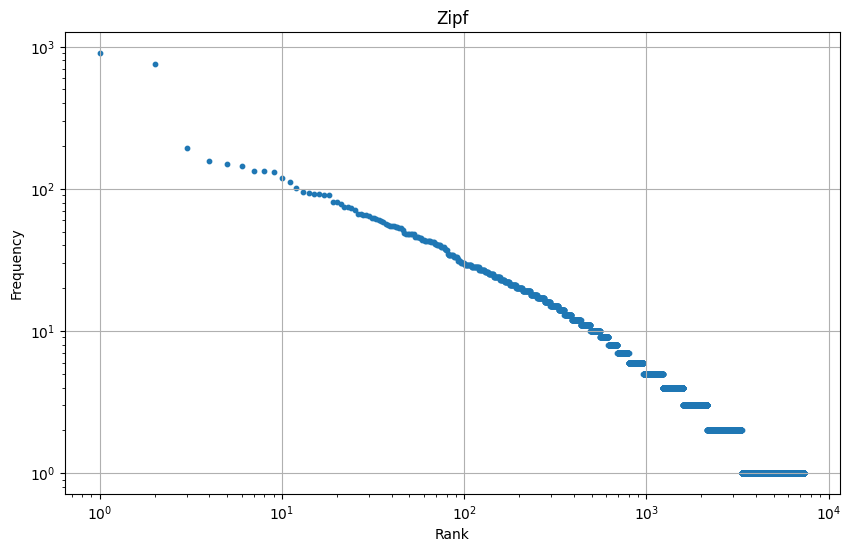

In [30]:
import matplotlib.pyplot as plt


frequencies = sorted(tf_tmp.values(), reverse=True)

ranks = range(1, len(frequencies) + 1)

plt.figure(figsize=(10, 6))

plt.scatter(ranks, frequencies, s=10)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Zipf')

plt.grid(True) 
plt.savefig("../outputs/ch04/result39.png")
plt.show()
